# Twitter NLP Analysis

## Overview

For this project we analyzed over 8,000 tweets from the 2011 SXSW festival. The dataframe used consisted of the text in the tweet, the sentiment of the tweet (rated by a human), and the product/brand the tweet was directed towards. Before modeling we performed a preprocessing approach that included:

- standardizing
- removing stopwords
- tokenizing
- stemming

Then we began to build models that aimed to predict the sentiment associated with each tweet. Our final model is 67% accurate. This is 7% more accurate than our dummy model. Throughout this process we reached the conclusion that designing products more similar to Apple's will receive better reactions from the public. Next steps include creating a binary model, using our model to analyze tweets after the 2024 SXSW event, and improving data collection.

## Business Problem

We are Orange, a tech company, looking to improve our next product release at SXSW 2024. This festival is a great opportunity for major tech companies like Google, Apple and now Orange, to reveal new products and obtain a good public image. By analyzing tweets from a previous SXSW event and the sentiment associated with each tweet we attempt to build a model that can predict the sentiment when given text from a tweet. This will help us in the future understand how our new products are being recepted by the public. 

For this project we chose accuracy as the metric to focus on. We decided that positive, negative, and neutral tweets all add value to determining how to handle product design in the future based on sentiment towards previous products. Given this train of thought we didn't find it necessary to optimize any class over the other and thought accuracy score would be best to use in order to evaluate our models.

## Data Understanding

The data comes from CrowdFlower via [data.world](https://data.world/crowdflower/brands-and-product-emotions). It consists of over 8,000 tweets about Apple and Google products from the 2011 South by Southwest (SXSW) event. Human raters rated the sentiment of the tweets as positive, negative, neutral, or indistinguishable. There are 3 columns including the tweet, the product the tweet is about, and the sentiment of the tweet. The variable we used as the target is sentiment. Our goal is to find key words in tweets that can be used to identify the sentiment of each tweet. 

#### Instructions for Downloading Data:
1. Go to [data.world](https://data.world/crowdflower/brands-and-product-emotions)
2. Click on the blue box labeled "Join to view this file"
3. Fill out the information in order to create an account
4. Now it will revert you back to the page and you can download the dataset

In [1]:
# Importing everything we will need
import pandas as pd
import numpy as np
import nltk
nltk.download('stopwords')
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from sklearn.feature_extraction.text import CountVectorizer
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, precision_score, ConfusionMatrixDisplay, recall_score, confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, HashingVectorizer
from sklearn.ensemble import StackingClassifier
from sklearn.preprocessing import StandardScaler

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/robertdaly/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
# Reading in the data
df = pd.read_csv("data/tweets.csv", encoding='latin1')
df.head()

,tweet_text,emotion_in_tweet_is_directed_at,is_there_an_emotion_directed_at_a_brand_or_product
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,iPhone,Negative emotion
1,@jessedee Know about @fludapp ? Awesome iPad/i...,iPad or iPhone App,Positive emotion
2,@swonderlin Can not wait for #iPad 2 also. The...,iPad,Positive emotion
3,@sxsw I hope this year's festival isn't as cra...,iPad or iPhone App,Negative emotion
4,@sxtxstate great stuff on Fri #SXSW: Marissa M...,Google,Positive emotion


In [3]:
df['emotion_in_tweet_is_directed_at'].value_counts()

iPad                               946
Apple                              661
iPad or iPhone App                 470
Google                             430
iPhone                             297
Other Google product or service    293
Android App                         81
Android                             78
Other Apple product or service      35
Name: emotion_in_tweet_is_directed_at, dtype: int64

In [4]:
df['is_there_an_emotion_directed_at_a_brand_or_product'].value_counts()

No emotion toward brand or product    5389
Positive emotion                      2978
Negative emotion                       570
I can't tell                           156
Name: is_there_an_emotion_directed_at_a_brand_or_product, dtype: int64

In [5]:
df.shape

(9093, 3)

In [6]:
df.isna().sum()

tweet_text                                               1
emotion_in_tweet_is_directed_at                       5802
is_there_an_emotion_directed_at_a_brand_or_product       0
dtype: int64

## Data Preparation

The steps we took to prepare our data before NLP processing included:
 - dropping a column
 - dropping a null
 - renaming a column
 - dropping tweets with 'I can't tell' as sentiment

The NLP steps performed included:
- standardizing
- removing stopwords
- tokenizing
- stemming

Dropped `emotion_in_tweet_is_directed_at` column because we focused on the relationship between the `tweet_text` and the sentiment of the respective tweet. 

In [7]:
# Dropping middle column in DataFrame
sent_df = df.drop('emotion_in_tweet_is_directed_at', axis=1)
sent_df.head()

,tweet_text,is_there_an_emotion_directed_at_a_brand_or_product
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,Negative emotion
1,@jessedee Know about @fludapp ? Awesome iPad/i...,Positive emotion
2,@swonderlin Can not wait for #iPad 2 also. The...,Positive emotion
3,@sxsw I hope this year's festival isn't as cra...,Negative emotion
4,@sxtxstate great stuff on Fri #SXSW: Marissa M...,Positive emotion


Dropped the one and only null row in the DataFrame.

In [8]:
# Dropping nulls
sent_df.dropna(inplace=True)

Changed `is_there_an_emotion_directed_at_a_brand_or_product` to `sentiment` to make it more manageable and interpretable.

In [9]:
# Changing name of column
sent_df['sentiment'] = sent_df['is_there_an_emotion_directed_at_a_brand_or_product']
sent_df.drop('is_there_an_emotion_directed_at_a_brand_or_product', axis = 1, inplace=True)

Based on "I can't tell" not being useful for our predictive model and there only being 156 corresponding data points, we decided to drop these rows.

In [10]:
sent_df.drop(sent_df.loc[sent_df['sentiment']=="I can't tell"].index, inplace=True)

### NLP Processing

We included hashtags in our Regex pattern becuase we thought hashtags can add valuable meaning in order to predict sentiment. However, we did not include mentions because these do not seem to add valuable meaning when predicting sentiment. We began with the corpus of stopwords from nltk. We added to the list of stopwords later when looking at a chart in our notebook showing the top tokens from each category. This will be explained more in depth later.

In [11]:
# Create an intance of the RegexpTokenizer with the variable name `tokenizer`
# The regex pattern should select all words with three or more characters
tokenizer = RegexpTokenizer(pattern=r"(?u)[\w#]{3,}")

# Create a list of stopwords in English
stopwords_list = stopwords.words('english')
# Add to stopwords_list here
stopwords_list.extend(['#sxsw', 'mention', 'googl', 'link', 'ipad','quot', 'appl', 'iphon', 'store', 'circl'])
stopwords_list.extend(['new','app','austin','like','launch','pop','sxsw', 'line', 'get', 'amp'])

# Create an instance of nltk's PorterStemmer with the variable name `stemmer`
stemmer = PorterStemmer()

Created a function that preproccesses the tweets by standardizing, tokenizing, removing stopwords, stemming, and removing tokens we decided to exclude after looking at the chart below. These were removed because they appeared commonly among all sentiments. These tokens had already been stemmed, this is why we remove stopwords again after the stemming in this function.

In [12]:
def preprocess_text(text, tokenizer, stopwords_list, stemmer):
    # Standardize case (lowercase the text)
    text = text.lower()
    # Tokenize text using `tokenizer`
    tokenized_text = tokenizer.tokenize(text)
    # Remove stopwords using `stopwords_list`
    filtered_text = [token for token in tokenized_text if token not in stopwords_list]
    # Stem the tokenized text using `stemmer`
    stemmed_text = [stemmer.stem(token) for token in filtered_text]
    # Remove stopword stems using extended `stopwords_list`
    stemmed_filtered_text = [token for token in stemmed_text if token not in stopwords_list]
    # Return the preprocessed text (do not join, just return the list of tokens)
    return stemmed_filtered_text
# Apply function to 'tweet_text' column
sent_df['preprocessed_text'] = sent_df['tweet_text'].apply(lambda x: preprocess_text(x, tokenizer, stopwords_list, stemmer))

Created three bar charts that display the top 10 most common tokens in each sentiment group (positive, negative, and neutral). These charts are how we decided which tokens needed to be added to our stopwords list. If a token was prevelant in all sentiment groups we added it to our stopwords list because these tokens do not add any value in determining sentiment. This process was repeated until we felt the top tokens were diverse and meaningful.

Paying attention to the class imbalance is important for this process. For example, in this final iteration of the charts, 'social' appears as a top token in the neutral and negative groups. The scales between these groups is substantial: 'social' appears about 30 times in the negative group and nearly 500 times in the neutral group. Due to this difference we decided not to add 'social' to our stopwords list.

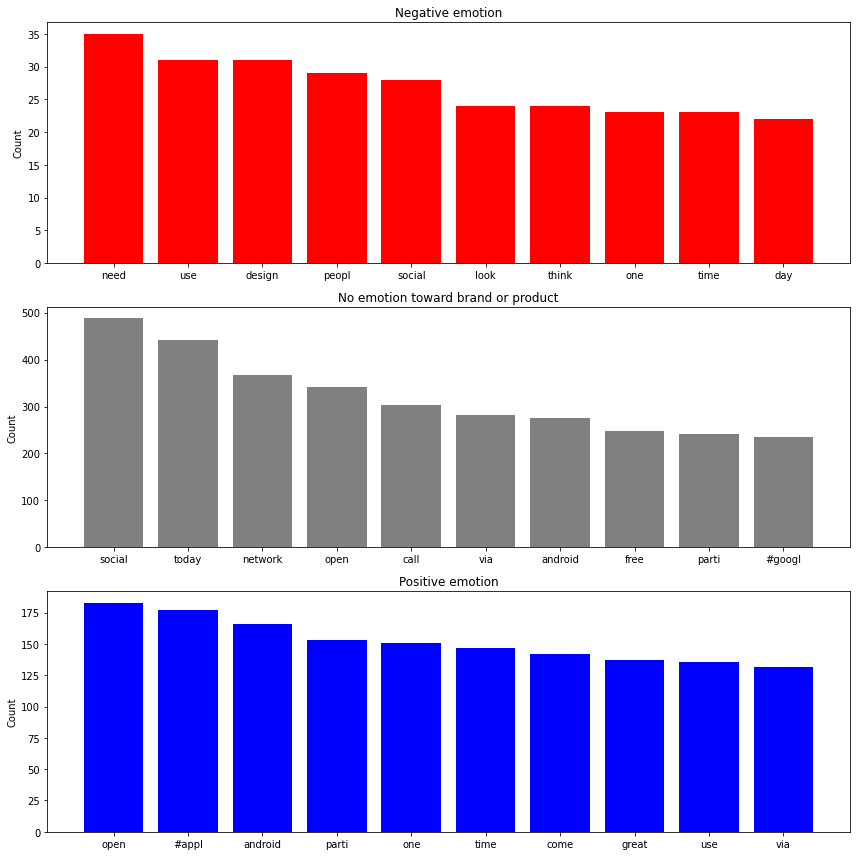

In [13]:
# Set up figure and axes
fig, axes = plt.subplots(nrows=3, figsize=(12, 12))

# Empty dict to hold words that have already been plotted and their colors
plotted_words_and_colors = {}
# Establish color palette to pull from
color_palette = sns.color_palette('cividis', n_colors=38)
# Create a plot for each unique sentiment
data_by_sent = [y for _, y in sent_df.groupby('sentiment', as_index=False)]
for idx, group in enumerate(data_by_sent):
    # Find top 10 words in each sentiment
    all_words_in_sent = group.preprocessed_text.explode()
    top_10 = all_words_in_sent.value_counts()[:10]
    
    # Select appropriate colors based on sentiment
    sentiment = group.iloc[0].sentiment  
    if sentiment == 'Negative emotion':
        color = 'red'  # red
    elif sentiment == 'No emotion toward brand or product':
        color = 'grey'  # grey
    elif sentiment == 'Positive emotion':
        color = 'blue'  # blue
    else:
        color = '#000000'  # default color if sentiment is not recognized

    # Select axes, plot data, set title
    ax = axes[idx]
    ax.bar(top_10.index, top_10.values, color=color)
    ax.set_title(sentiment)
    ax.set_ylabel("Count")

fig.tight_layout()

Once all the actions above were completed, the data was ready for a train/test split in order to begin the modeling process.

In [14]:
# Convert token lists to strings
sent_df["joined_preprocessed_text"] = sent_df["preprocessed_text"].str.join(" ")

# Create train test split
X = sent_df['joined_preprocessed_text']
y = sent_df['sentiment']
# Explain zoom room 3 here
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=333)

X_train

7817    everyon alreadi one anti theft protect leav la...
3158                             kick talk design headach
7555    frabjou day callooh callay baaah ûólewi carrol...
6829            umm would keep win shit thank killer case
3719                    design interfac navig schema #uxd
                              ...                        
5593    cameron sinclair spearhead japan disast relief...
7664                   #ipad therefor #appl near send pic
6173               crazi look around realiz last year one
987              nice outsid #appl guess peopl want ipad2
8310                              might well popup #ipad2
Name: joined_preprocessed_text, Length: 6702, dtype: object

In [15]:
y_train.value_counts()

No emotion toward brand or product    4068
Positive emotion                      2201
Negative emotion                       433
Name: sentiment, dtype: int64

## Modeling

In order to analyze the performance of models we built, we focused on accuracy. We decided this was best because we felt negative and positive sentiment towards a brand/product are equally important. The negatives inform what needs to be changed and what could be different. Positives inform what should stay the same and the strengths of a company/product. If we chose recall or precision we would be focusing more on one than the other.

For this problem we needed to use classification models. There are many options to use and we weren't sure which would be most appropriate so we created a wide variety. First, we started with a decision tree purposefully trying to overfit the model to confirm that we had the right data in order to build a successful predictive model.

Every iteration of our models was highly focused on reducing overfitting while maintaining or increasing the accuracy score.

## Evaluation


### Baseline Understanding

The most dominant sentiment in the data is neutral, therefore we set our baseline accuracy as a model predicting neutral sentiment every time. This would result in an accuracy score of approximately 60%. 

In [16]:
# Setting baseline_accuracy equal to the normalized value_counts of neutral sentiment
baseline_accuracy = sent_df['sentiment'].value_counts(normalize=True)[0]
baseline_accuracy

0.6029543419874664

### First Model (Decision Tree)

Created a decision tree model with all default parameters. Our goal here was to purposefully create an overfit model in order to confirm it achieves a high accuracy score. Accomplishing this tells us we are using good enough data in order to predict our target variable. 

In [17]:
# Creating steps for a Pipeline 
tree_steps = [('cv', CountVectorizer(stop_words='english')),
         ('tree', DecisionTreeClassifier())]
# Feeding the Pipeline the steps defined above
tree_pipe = Pipeline(tree_steps)
# Fitting the training data to the Pipeline
tree_pipe.fit(X_train, y_train)

Pipeline(steps=[('cv', CountVectorizer(stop_words='english')),
                ('tree', DecisionTreeClassifier())])

This worked successfully, this model received an accuracy score of 95.17% on the training data.

In [18]:
# Defining the predictions from the Pipeline using the training data
y_pred = tree_pipe.predict(X_train)
# Evaluating the accuracy score on the training data
accuracy_score(y_train, y_pred)

0.9571769621008654

But, the cross_val_score is much lower (65%) showing this model is very overfit. This is still performing a little better than the baseline model.

In [19]:
# Calculating mean of the 5-fold cross_val_score
cross_val_score(tree_pipe, X_train, y_train, cv=5).mean()

0.6520451434104645

### Second Model (Random Forest)

Created a Random Forest model with default parameters. Added max_features=2000 to the vectorizer in order to help reduce overfitting.

In [20]:
# Creating steps for a Pipeline 
forest_steps = [('cv', CountVectorizer(stop_words='english', max_features=2000)),
         ('forest', RandomForestClassifier(random_state=333))]
# Feeding the Pipeline the steps defined above
forest_pipe = Pipeline(forest_steps)
# Fitting the training data to the Pipeline
forest_pipe.fit(X_train, y_train)

Pipeline(steps=[('cv',
                 CountVectorizer(max_features=2000, stop_words='english')),
                ('forest', RandomForestClassifier(random_state=333))])

Again, this random forest model earned a high accuracy score on the training data but it is most likely due to overfitting.

In [21]:
# Defining the predictions from the Pipeline using the training data
y_pred = forest_pipe.predict(X_train)
# Evaluating the accuracy score on the training data
accuracy_score(y_train, y_pred)

0.9507609668755596

The cross validation score is a bit higher than it was for the decision tree model. This random forest model is still very overfit to the training data.

In [22]:
# Calculating mean of the 5-fold cross_val_score
cross_val_score(forest_pipe, X_train, y_train, cv=5, scoring='accuracy', n_jobs=3).mean()

0.6735296671007378

### Random Forest with GridSearch

In order to combat the overfit results we used a GridSearch to help tune the hyperparameters.

In [23]:
# Creating parameters for GridSearch
params = {'forest__max_depth': [50, 75, 100],
         'forest__max_features': [750, 1000, 1250],
         'forest__n_estimators': [12, 15, 18]}
# GridSearch with the random forest pipeline, parameters above, 5 fold cross validation, and accuracy score
forest_grid = GridSearchCV(estimator=forest_pipe, param_grid=params, cv=5, scoring='accuracy', n_jobs=3)
# Fitting the GridSearch
forest_grid.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('cv',
                                        CountVectorizer(max_features=2000,
                                                        stop_words='english')),
                                       ('forest',
                                        RandomForestClassifier(random_state=333))]),
             n_jobs=3,
             param_grid={'forest__max_depth': [50, 75, 100],
                         'forest__max_features': [750, 1000, 1250],
                         'forest__n_estimators': [12, 15, 18]},
             scoring='accuracy')

The GridSearch discovered max_depth=75, max_features=1000, and n_estimators=18 had the best cross validation score. This is almost the same score as before but should be much less overfit considering the hyperparameters.

In [24]:
# Displaying the best estimator from the GridSearch and the accuracy score
print(forest_grid.best_estimator_)
print(forest_grid.best_score_)

Pipeline(steps=[('cv',
                 CountVectorizer(max_features=2000, stop_words='english')),
                ('forest',
                 RandomForestClassifier(max_depth=75, max_features=1000,
                                        n_estimators=18, random_state=333))])
0.6799451289414227


### Updated Params (1st time)

Tried to improve results with new GridSearch.

In [25]:
# Creating parameters for GridSearch
params2 = {'forest__max_depth': [60, 75, 90],
         'forest__max_features': [900, 1000, 1100],
         'forest__n_estimators': [17, 18, 19]}
# GridSearch with the random forest pipeline, parameters above, 5 fold cross validation, and accuracy score
forest_grid2 = GridSearchCV(estimator=forest_pipe, param_grid=params2, cv=5, scoring='accuracy', n_jobs=3)
# Fitting the GridSearch
forest_grid2.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('cv',
                                        CountVectorizer(max_features=2000,
                                                        stop_words='english')),
                                       ('forest',
                                        RandomForestClassifier(random_state=333))]),
             n_jobs=3,
             param_grid={'forest__max_depth': [60, 75, 90],
                         'forest__max_features': [900, 1000, 1100],
                         'forest__n_estimators': [17, 18, 19]},
             scoring='accuracy')

The GridSearch discovered max_depth=90, max_features=900, and n_estimators=17 had the best cross validation score. This is right around the same score as the random forest model with default parameters but should be less overfit to the data considering the hyperparameters.

In [26]:
# Displaying the best estimator from the GridSearch and the accuracy score
print(forest_grid2.best_estimator_)
print(forest_grid2.best_score_)

Pipeline(steps=[('cv',
                 CountVectorizer(max_features=2000, stop_words='english')),
                ('forest',
                 RandomForestClassifier(max_depth=90, max_features=900,
                                        n_estimators=17, random_state=333))])
0.6818855387492071


### Updated Params (2nd time)

Tried to improve results with new GridSearch.

In [27]:
# Creating parameters for GridSearch
params3 = {'forest__max_depth': [75, 90, 100],
         'forest__max_features': [850, 900, 950],
         'forest__n_estimators': [16, 17, 18]}
# GridSearch with the random forest pipeline, parameters above, 5 fold cross validation, and accuracy score
forest_grid3 = GridSearchCV(estimator=forest_pipe, param_grid=params3, cv=5, scoring='accuracy', n_jobs=3)
# Fitting the GridSearch
forest_grid3.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('cv',
                                        CountVectorizer(max_features=2000,
                                                        stop_words='english')),
                                       ('forest',
                                        RandomForestClassifier(random_state=333))]),
             n_jobs=3,
             param_grid={'forest__max_depth': [75, 90, 100],
                         'forest__max_features': [850, 900, 950],
                         'forest__n_estimators': [16, 17, 18]},
             scoring='accuracy')

This GridSearch returned the same results as the previous one. We decided to move on to another model instead of tweaking this one more.

In [28]:
# Displaying the best estimator from the GridSearch and the accuracy score
print(forest_grid3.best_estimator_)
print(forest_grid3.best_score_)

Pipeline(steps=[('cv',
                 CountVectorizer(max_features=2000, stop_words='english')),
                ('forest',
                 RandomForestClassifier(max_depth=90, max_features=900,
                                        n_estimators=17, random_state=333))])
0.6818855387492071


### Third Model (Logistic Regression)

Created a logistic regression model with an awareness that logistic regression does not handle class imbalances as well as decision trees/random forests. Used max_features=900 in the vectorizer because it worked the best from the GridSearch with the random forest model.

In [29]:
# Creating steps for a Pipeline 
logreg_steps = [('cv', CountVectorizer(stop_words='english', max_features=900)),
         ('logreg', LogisticRegression(random_state=333, max_iter=1000))]
# Feeding the Pipeline the steps defined above
logreg_pipe = Pipeline(logreg_steps)
# Fitting the training data to the Pipeline
logreg_pipe.fit(X_train, y_train)

Pipeline(steps=[('cv', CountVectorizer(max_features=900, stop_words='english')),
                ('logreg',
                 LogisticRegression(max_iter=1000, random_state=333))])

This logistic regression has a 75% accuracy score which is pretty high but it could be overfit to the training data and probably isn't doing well with the class imbalance.

In [30]:
# Defining the predictions from the Pipeline using the training data
y_pred = logreg_pipe.predict(X_train)
# Evaluating the accuracy score on the training data
accuracy_score(y_train, y_pred)

0.7588779468815279

This model is overfit but not as bad as the base random tree or base random forest models.

In [31]:
# Calculating mean of the 5-fold cross_val_score
cross_val_score(logreg_pipe, X_train, y_train, cv=5, scoring='accuracy', n_jobs=3).mean()

0.6730829076096029

Created confusion matrix in order to investigate how the model is handling the class imbalance. It shows that this model is struggling predicting the negative and positive sentiments accurately but is doing pretty well with the neutral sentiment becuase most of the data is neutral. 

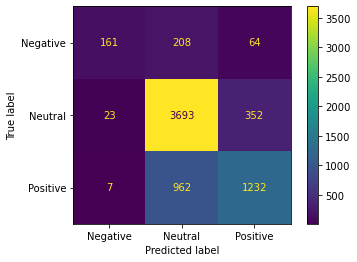

In [32]:
# Creating confusion matrix
cf = confusion_matrix(y_train, y_pred)
# Displaying confusion matrix
ConfusionMatrixDisplay(cf, display_labels=['Negative', 'Neutral', 'Positive']).plot()

### Logistic Regression with GridSearch

In order to combat the poor performance due to overfitting and the class imbalance, we used a GridSearch to help tune the hyperparameters. Using a class weight 'balanced' should help with the class imbalance problem, lower C will enforce stricter regularization helping with overfitting.

In [33]:
# Creating parameters for GridSearch
logreg_params = {'logreg__class_weight':['balanced', [4, 1, 2]],
                'logreg__C': [0.1, 0.01, 0.001],
                'logreg__solver': ['lbfgs', 'sag', 'newton-cg', 'saga'],
                'logreg__max_iter': [5000],
                'logreg__penalty': ['l1', 'l2', 'elasticnet']}
# GridSearch with the logistic regression pipeline, parameters above, 5 fold cross validation, and accuracy score
logreg_grid = GridSearchCV(estimator=logreg_pipe, param_grid=logreg_params, cv=5, scoring='accuracy', n_jobs=3)
# Fitting the GridSearch
logreg_grid.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('cv',
                                        CountVectorizer(max_features=900,
                                                        stop_words='english')),
                                       ('logreg',
                                        LogisticRegression(max_iter=1000,
                                                           random_state=333))]),
             n_jobs=3,
             param_grid={'logreg__C': [0.1, 0.01, 0.001],
                         'logreg__class_weight': ['balanced', [4, 1, 2]],
                         'logreg__max_iter': [5000],
                         'logreg__penalty': ['l1', 'l2', 'elasticnet'],
                         'logreg__solver': ['lbfgs', 'sag', 'newton-cg',
                                            'saga']},
             scoring='accuracy')

The GridSearch discovered C=0.1, max_iter=5000, balanced weights, and solver='lbgfs' had the best cross validation score. This is a lot worse than our logistic regression with all default settings. We expected this becuase we reduced overfitting.

In [34]:
print(logreg_grid.best_estimator_)
print(logreg_grid.best_score_)

Pipeline(steps=[('cv', CountVectorizer(max_features=900, stop_words='english')),
                ('logreg',
                 LogisticRegression(C=0.1, class_weight='balanced',
                                    max_iter=5000, random_state=333))])
0.5874379778957561


### Fourth Model (Multinomial Naive Bayes)

Created a Multinomial Naive Bayes (MNB) model. Kept the max_features=900 in the vectorizer to reduce overfitting again.

In [35]:
# Creating steps for a Pipeline 
mnb_steps = [('tfidf', TfidfVectorizer(max_features=900)),
             ('mnb', MultinomialNB())]
# Feeding the Pipeline the steps defined above
mnb_pipe = Pipeline(mnb_steps)
# Fitting the training data to the Pipeline
mnb_pipe.fit(X_train, y_train)

Pipeline(steps=[('tfidf', TfidfVectorizer(max_features=900)),
                ('mnb', MultinomialNB())])

This was a lower accuracy score on the training data than on previous models that sparked hope it was not overfit.

In [36]:
# Defining the predictions from the Pipeline using the training data
y_pred = mnb_pipe.predict(X_train)
# Evaluating the accuracy score on the training data
accuracy_score(y_train, y_pred)

0.7168009549388242

This was a pretty low cross validation score and is in line with our previous models. It seemed to be a little less overfit than the previous models but, still is overfit on the training data.

In [37]:
# Calculating mean of the 5-fold cross_val_score
cross_val_score(mnb_pipe, X_train, y_train, cv=5, scoring='accuracy', n_jobs=3).mean()

0.6695008180573643

### MNB with GridSearch

Tried to improve the MNB model by adjusting hyperparameters using a GridSearch.

In [38]:
# Creating parameters for GridSearch
mnb_params = {'mnb__alpha':[1, 0.5, 0],
          'mnb__fit_prior':[True, False]}
# GridSearch with the mnb pipeline, parameters above, 5 fold cross validation, and accuracy score
mnb_grid = GridSearchCV(estimator=mnb_pipe, param_grid=mnb_params, cv=5, scoring='accuracy', n_jobs=3)
# Fitting the GridSearch
mnb_grid.fit(X_train, y_train)

/Users/robertdaly/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/naive_bayes.py:511: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn('alpha too small will result in numeric errors, '


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('tfidf',
                                        TfidfVectorizer(max_features=900)),
                                       ('mnb', MultinomialNB())]),
             n_jobs=3,
             param_grid={'mnb__alpha': [1, 0.5, 0],
                         'mnb__fit_prior': [True, False]},
             scoring='accuracy')

This did not improve much from the accuracy score using the defualt parameters but, it did improve about 0.4%.

In [39]:
print(mnb_grid.best_estimator_)
print(mnb_grid.best_score_)

Pipeline(steps=[('tfidf', TfidfVectorizer(max_features=900)),
                ('mnb', MultinomialNB(alpha=0))])
0.673380302069073


### Final Model (Stacking Random Forest, Logistic Regression, and MNB Models)

Attempted to make an improved model by stacking our best iterations of the other models together.

In [40]:
# Defining the estimators to feed the stacked classifier
estimators = [('forest', RandomForestClassifier(max_depth=90, max_features=900, n_estimators=17, random_state=333)),
              ('logreg', LogisticRegression(C=0.1, class_weight='balanced', max_iter=5000, random_state=333)),
              ('mnb', MultinomialNB(alpha=1.0e-10))]

In [41]:
# Feeding the estimators to teh stacking classifier
sc = StackingClassifier(estimators=estimators)
# Instantiating standard scaler
scaler = StandardScaler(with_mean=False)

# Creating stacking classifier Pipeline
sc_pipe = Pipeline(steps=[('tfidf', TfidfVectorizer(max_features=900)),
                          
                          ('sc', sc)])

In [42]:
# Fitting the training data to the StackedClassifier Pipeline
sc_pipe.fit(X_train, y_train)

Pipeline(steps=[('tfidf', TfidfVectorizer(max_features=900)),
                ('sc',
                 StackingClassifier(estimators=[('forest',
                                                 RandomForestClassifier(max_depth=90,
                                                                        max_features=900,
                                                                        n_estimators=17,
                                                                        random_state=333)),
                                                ('logreg',
                                                 LogisticRegression(C=0.1,
                                                                    class_weight='balanced',
                                                                    max_iter=5000,
                                                                    random_state=333)),
                                                ('mnb',
                                             

Received an accuracy score of 81.2% on the training data with the StackedClassifier model.

In [43]:
# Defining the predictions from the Pipeline using the training data
y_pred = sc_pipe.predict(X_train)
# Evaluating the accuracy score on the training data
accuracy_score(y_train, y_pred)

0.8119964189794091

This cross valuation score of 68.35% is the best we earned so far.

In [44]:
# Calculating mean of the 5-fold cross_val_score
cross_val_score(sc_pipe, X_train, y_train, cv=5, scoring='accuracy', n_jobs=3).mean()

0.6835261054904448

We spent a lot of time changing the hyperparameters on this StackedClassifier model. Nothing improved the cross validation score. We tried changing the final_estimator, max_features in the vectorizer, and much more. 

We decided to use this as our final model and use it on the testing data. It is an overfit model but so were all of the others and it received the highest cross validation score. However, it was a bit disappointing considering it is only about 8% more accurate than our dummy model.

# Conclusion
When deployed on the testing data it received an accuracy score of 67% this is comparable to the cross validation score and was expected.

In [45]:
# Defining the predictions from the Pipeline using the testing data
y_pred = sc_pipe.predict(X_test)
# Getting the accuracy score on the testing data
accuracy_score(y_test, y_pred)

0.6709937332139659

There were two huge challenges when creating this model:

1. combat overfitting
2. dealing with the class imbalance

There were a tiny amount of negative tweets compared to neutral tweets. There were more positive tweets than negative but, not nearly as many positive tweets as neutral tweets. Our model struggled predicting negative and positive tweets as shown by this confusion matrix. Majority of the time the model predicts neutral because of this class imbalance.

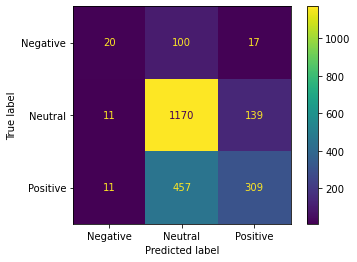

In [46]:
# Creating confusion matrix with the testing data
cf = confusion_matrix(y_test, y_pred)
# Displaying the confusion matrix
ConfusionMatrixDisplay(cf, display_labels=['Negative', 'Neutral', 'Positive']).plot()

## Next Steps


After our research, we recommend creating another model attempting to solve the same problem but, create a binary classification problem using positive and negative. Neutral tweets do not add much value in the big picture and created a distinct class imbalance making it difficult to create a successful model.

In the meantime, we could still use this model at SXSW 2024 in order to obtain knowlegde on public sentiment of our products that we launch at the event. 

Improving the data collection process would also be useful. The data we had access to had many nulls in the product column. We were able to distinguish between Apple and Google with the data at hand. With improved data we could get more granular and discover which specific products the sentiment is directed towards rather than just the company.